# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

# Original Data (via lxml scraper)

In [2]:
df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()

(2532, 7)


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Jun 16, 2020",1011.85,1012.88,962.54,982.13,982.13,13927005
1,"Jun 15, 2020",917.79,998.84,908.50,990.90,990.90,15662200
2,"Jun 12, 2020",980.00,987.98,912.60,935.28,935.28,16730200
3,"Jun 11, 2020",990.20,1018.96,972.00,972.84,972.84,15916500
4,"Jun 10, 2020",991.88,1027.48,982.50,1025.05,1025.05,18563400


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace = True)
df.sort_index(inplace = True)

df.columns = df.columns.map(lambda x: x.lower().replace('*', '').replace(' ', '_'))

df['daily_returns'] = df['close'].pct_change()

df.head()

,open,high,low,close,adj_close,volume,daily_returns
Date,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300,NaN
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937


In [4]:
print(df.shape)
df = df.resample('D').first().ffill()
print(df.isna().sum())

df

(2532, 7)
open             0
high             0
low              0
close            0
adj_close        0
volume           0
daily_returns    1
dtype: int64


,open,high,low,close,adj_close,volume,daily_returns
Date,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300.0,NaN
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100.0,-0.002512
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800.0,-0.078473
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683
2010-07-03,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683
...,...,...,...,...,...,...,...
2020-06-12,980.00,987.98,912.60,935.28,935.28,16730200.0,-0.038609
2020-06-13,980.00,987.98,912.60,935.28,935.28,16730200.0,-0.038609
2020-06-14,980.00,987.98,912.60,935.28,935.28,16730200.0,-0.038609


# Visualize the Original Time Series 

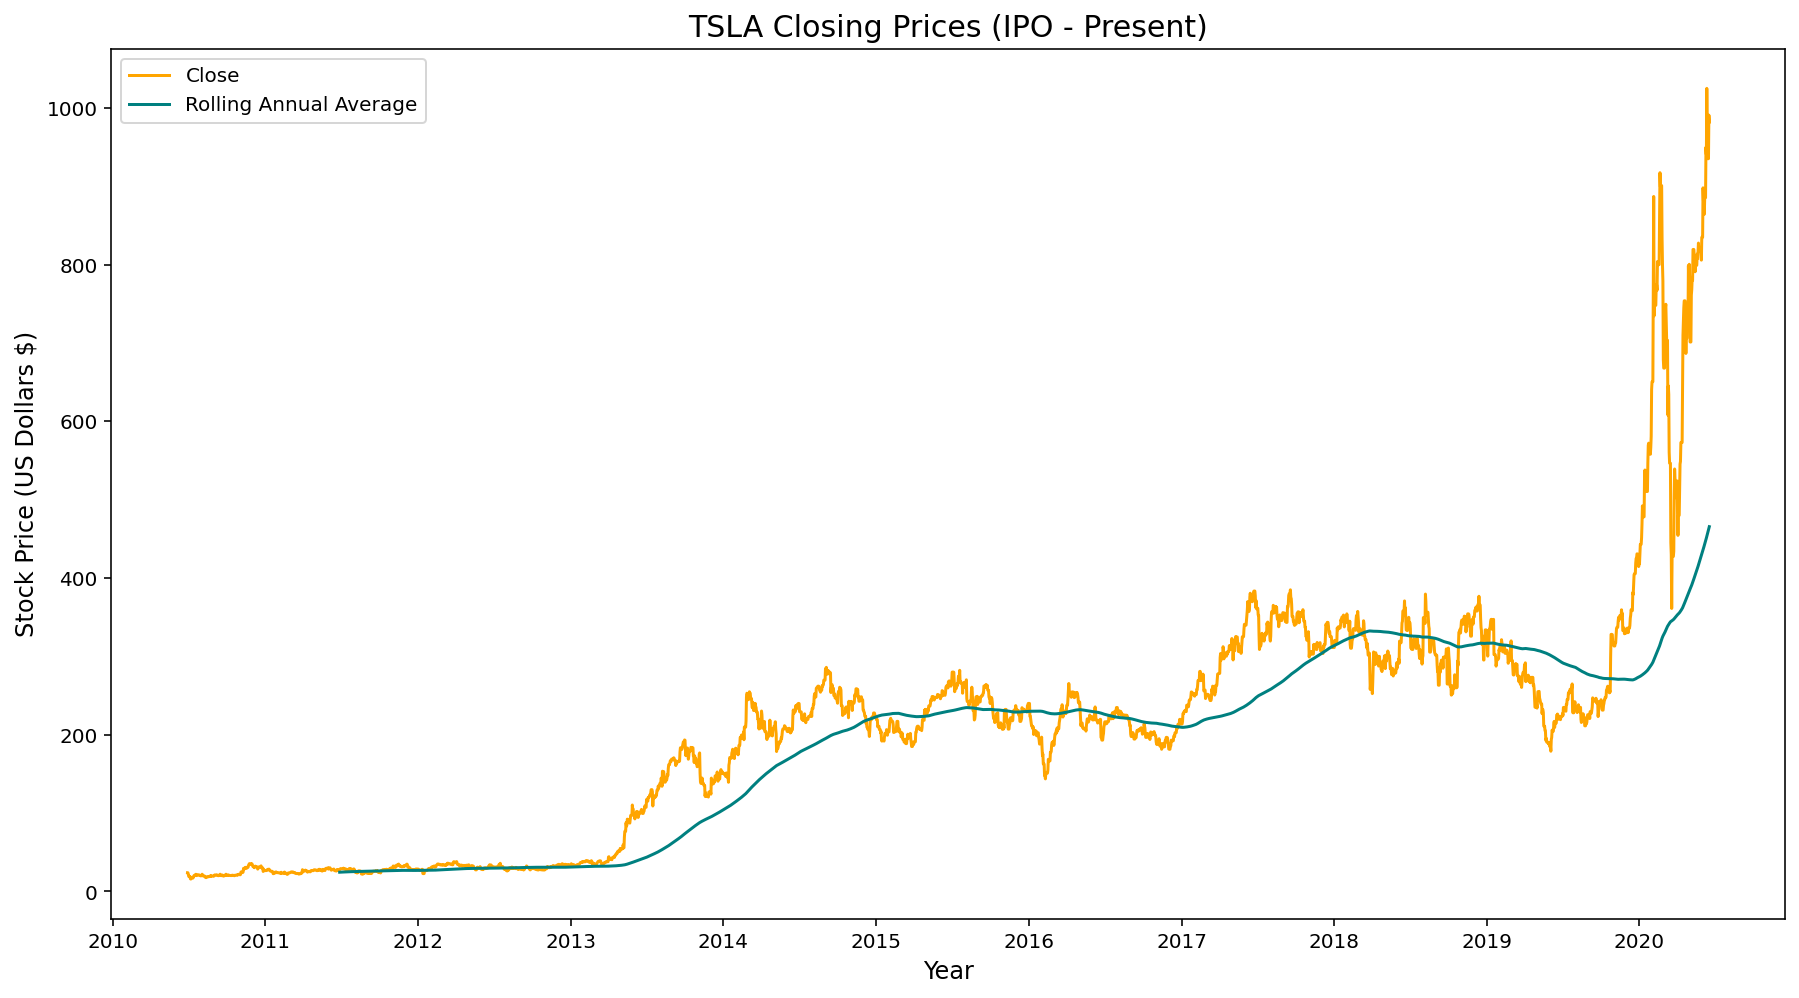

In [5]:
plt.figure(figsize = (15, 8))
plt.plot(df['close'], label = 'Close', color = 'orange')
plt.plot(df['close'].rolling(365).mean(), label = 'Rolling Annual Average', color = 'teal')
plt.xlabel('Year', size = 12)
plt.ylabel('Stock Price (US Dollars $)', size = 12)
plt.title('TSLA Closing Prices (IPO - Present)', size = 15)
plt.legend();

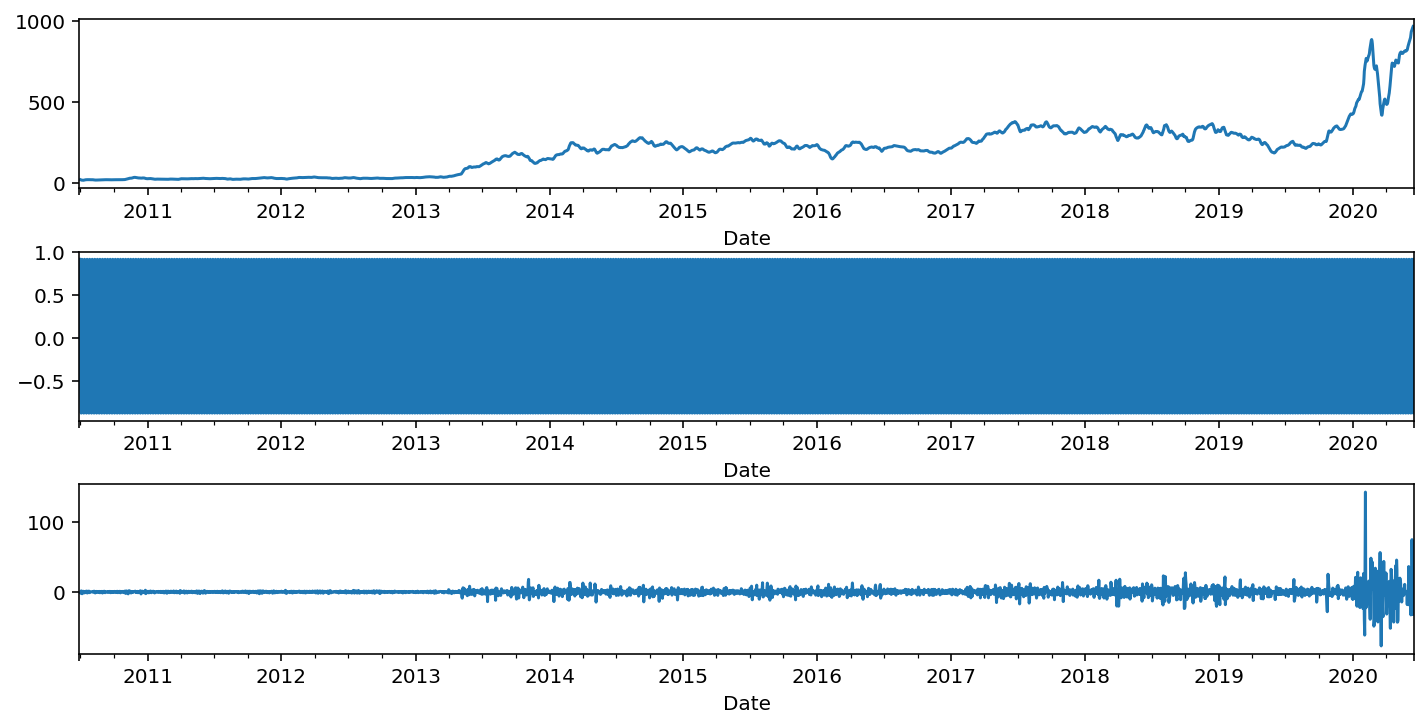

In [6]:
fig, ax = plt.subplots(nrows = 3, figsize = (10, 5))
plt.tight_layout()

m = seasonal_decompose(df['close'])

# Visually, there doesn't appear to be any seasonality in our data. 
# There is, however, an obvious trend (possibly exponential) The seasonal component provided
# is probably not helpful in our analysis in this case.

m.trend.plot(ax = ax[0])
m.seasonal.plot(ax = ax[1])
m.resid.plot(ax = ax[2]);

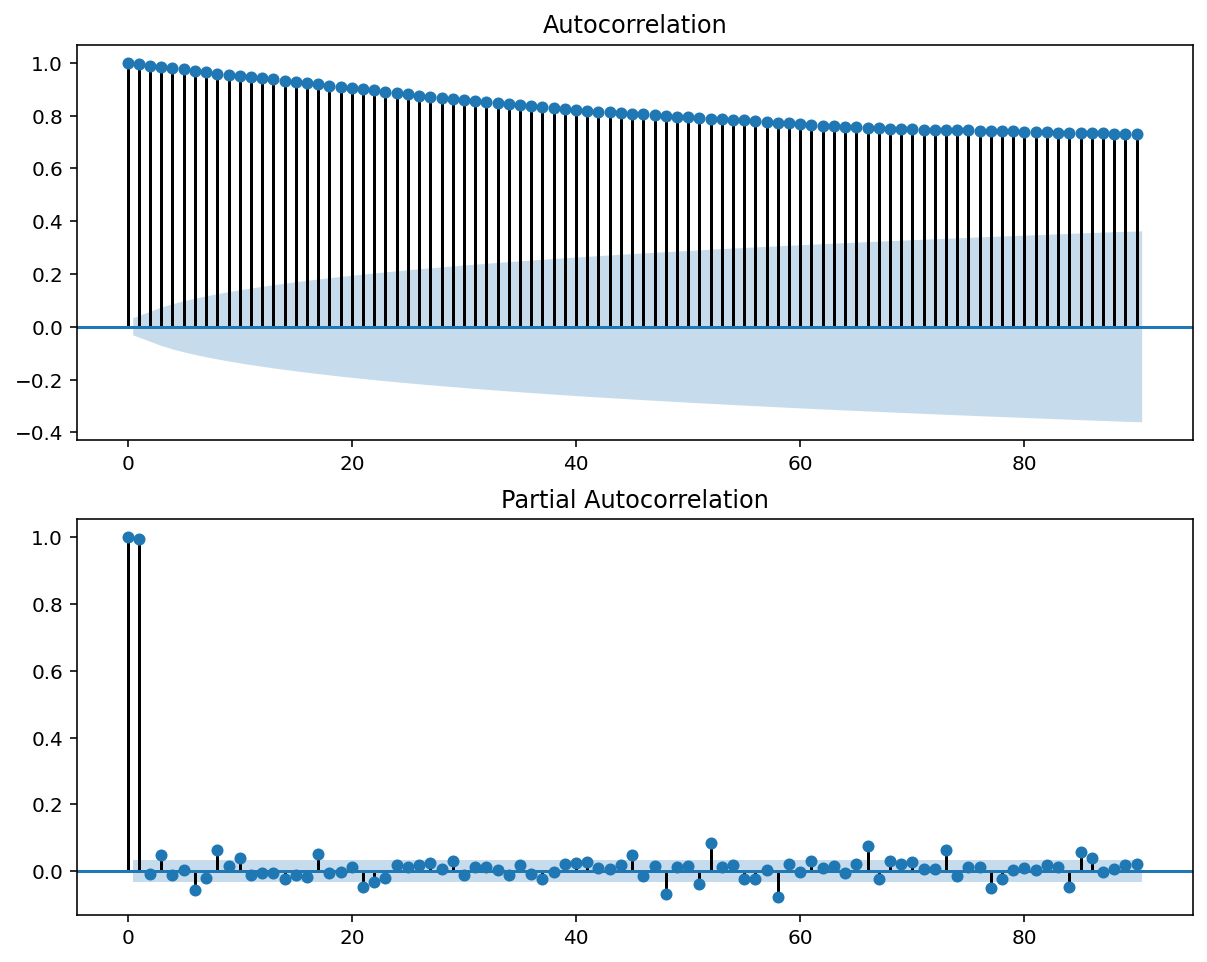

In [7]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
# We can immediately tell that the data needs to be stationarized based on how
# many lags it takes before the ACF values cut off below our 95% confidence interval
# But we should still perform an ADFuller test to confirm
plot_acf(df['close'], lags = 90, ax = ax[0])

# Just by eyeballing the PACF chart, we can't confirm whether or not seasonality exists.
# We can see that there is some variation explained by certain lags around 30 days, 60 days, and 90 days
plot_pacf(df['close'], lags = 90, ax = ax[1]);

# First Difference of Closing Price

In [8]:
# Adapted function from ARIMA lecture by Matt Brems
def adf_results(data):
    adf = adfuller(data)
    results = pd.Series(adf[0:2], index = ['Test Statistic', 'p-value'])
    
    return results

# We're setting alpha = 0.01
# Because our p-value is way higher than alpha, we do not have enough evidence to reject the null hypothesis
# and therefore cannot conclude that our data is stationary. 
print(adf_results(df['close']), '\n')
# We've computed a p-value lower than our alpha level of 0.05. We can proceed with modeling our differenced data.
print(adf_results(df['close'].diff().dropna()))

Test Statistic    1.613081
p-value           0.997896
dtype: float64 

Test Statistic   -1.208995e+01
p-value           2.133992e-22
dtype: float64


In [9]:
# Taking the first-difference of our closing data
df['diff_close'] = df['close'].diff()
df.head()

,open,high,low,close,adj_close,volume,daily_returns,diff_close
Date,,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300.0,NaN,NaN
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100.0,-0.002512,-0.06
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800.0,-0.078473,-1.87
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683,-2.76
2010-07-03,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683,0.00


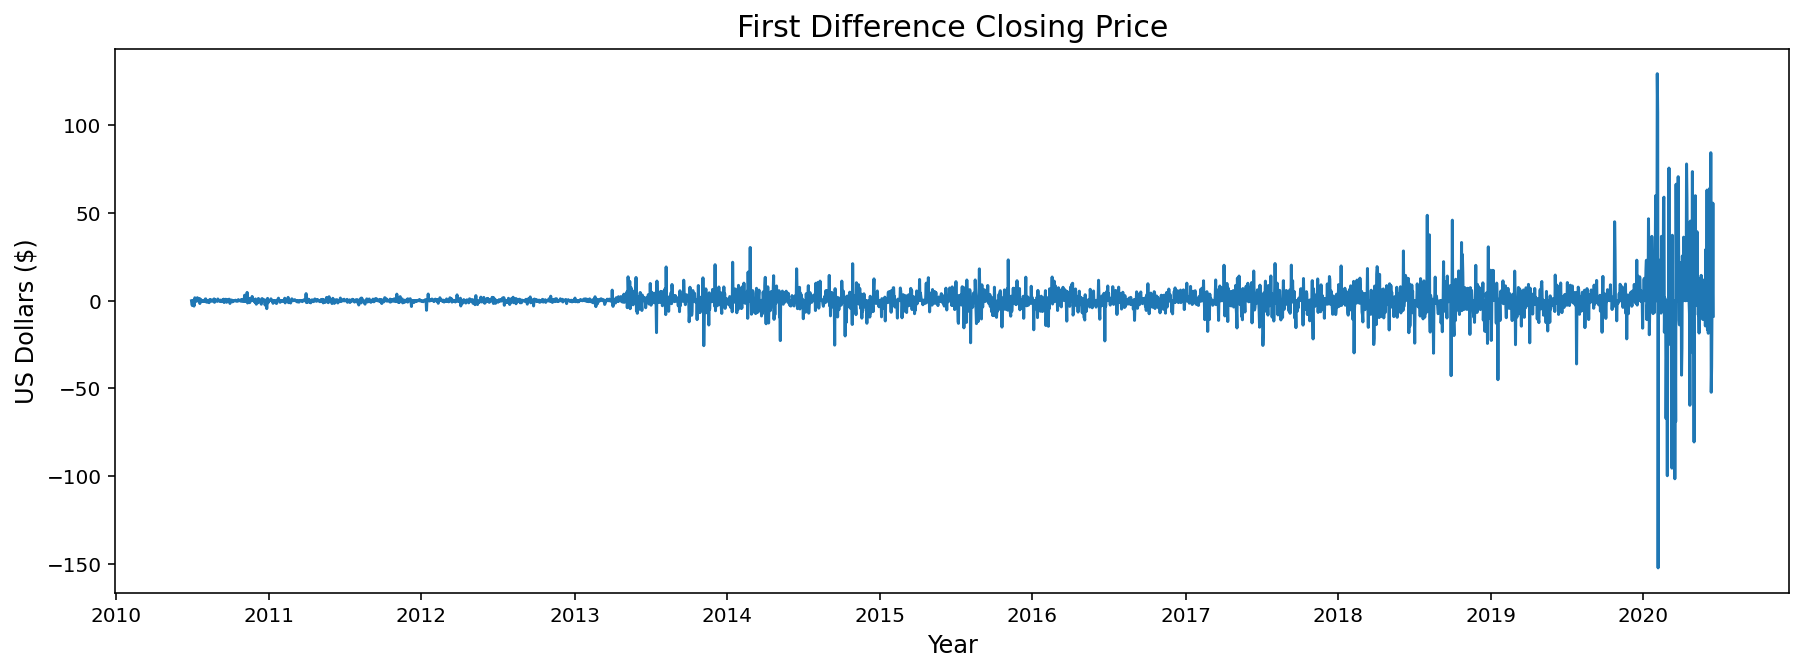

In [10]:
plt.figure(figsize = (15, 5))
plt.plot(df['diff_close'])
plt.xlabel('Year', size = 12)
plt.ylabel('US Dollars ($)', size = 12)
plt.title('First Difference Closing Price', size = 15);

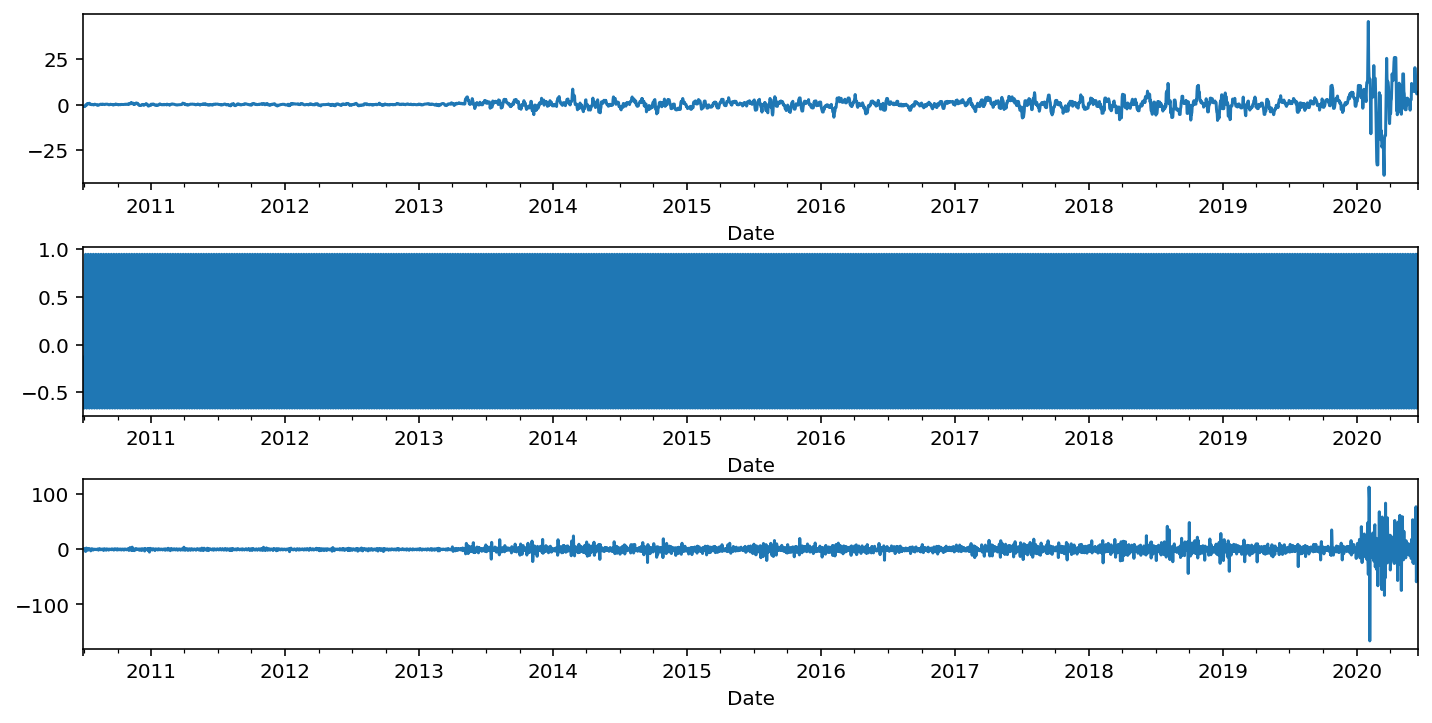

In [11]:
fig, ax = plt.subplots(nrows = 3, figsize = (10, 5))
plt.tight_layout()

m = seasonal_decompose(df['diff_close'].dropna())

# Visually, there doesn't appear to be any seasonality in our data. 
# There is, however, an obvious trend (possibly exponential) The seasonal component provided
# is probably not helpful in our analysis in this case.

m.trend.plot(ax = ax[0])
m.seasonal.plot(ax = ax[1])
m.resid.plot(ax = ax[2]);

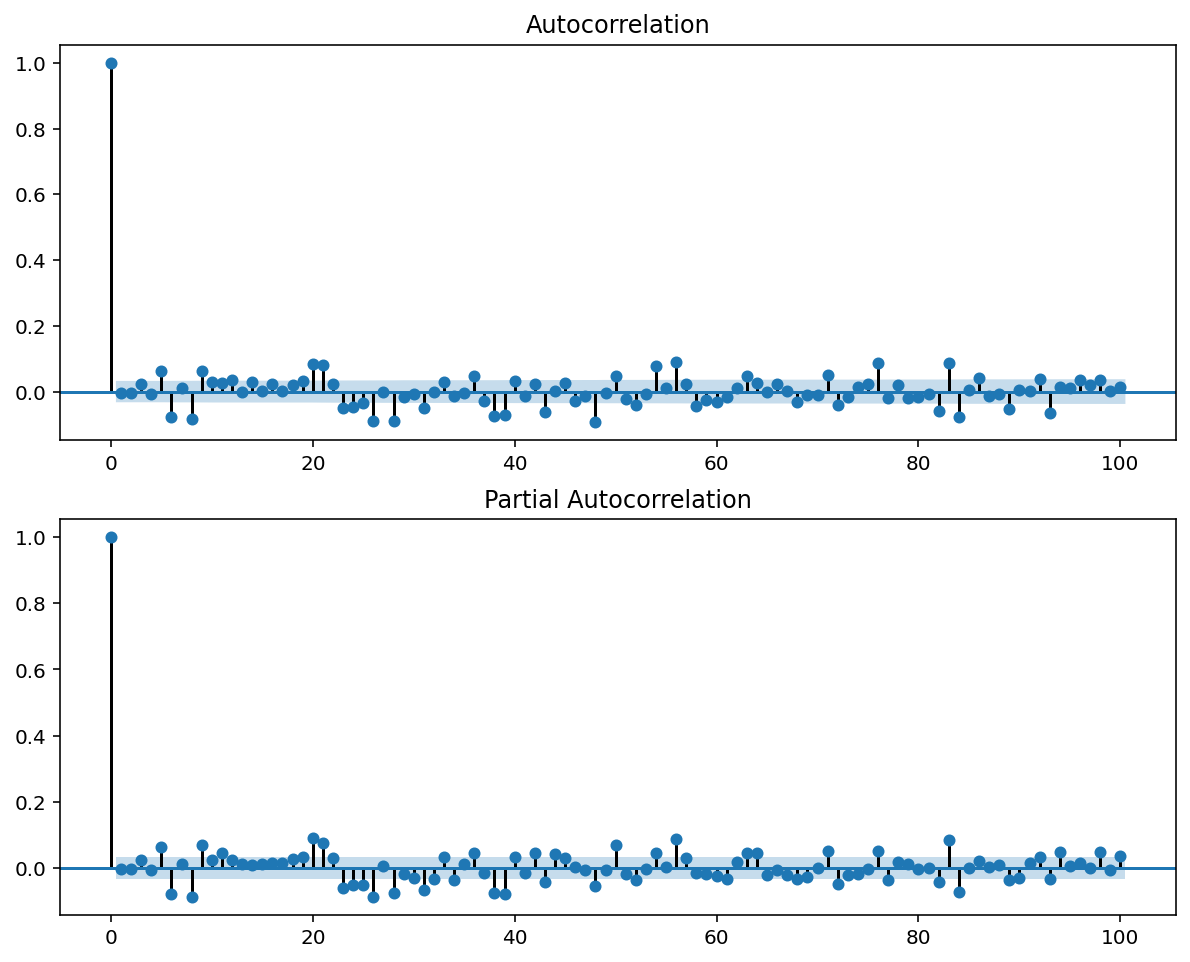

In [12]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
plot_acf(df['diff_close'].dropna(), lags = 100, ax = ax[0])
plot_pacf(df['diff_close'].dropna(), lags = 100, ax = ax[1]);

# Second Difference Closing Price

In [13]:
df['diff_close_2'] = df['close'].diff().diff()
df.head()

,open,high,low,close,adj_close,volume,daily_returns,diff_close,diff_close_2
Date,,,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300.0,NaN,NaN,NaN
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100.0,-0.002512,-0.06,NaN
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800.0,-0.078473,-1.87,-1.81
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683,-2.76,-0.89
2010-07-03,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683,0.00,2.76


Test Statistic   -1.432943e+01
p-value           1.106308e-26
dtype: float64


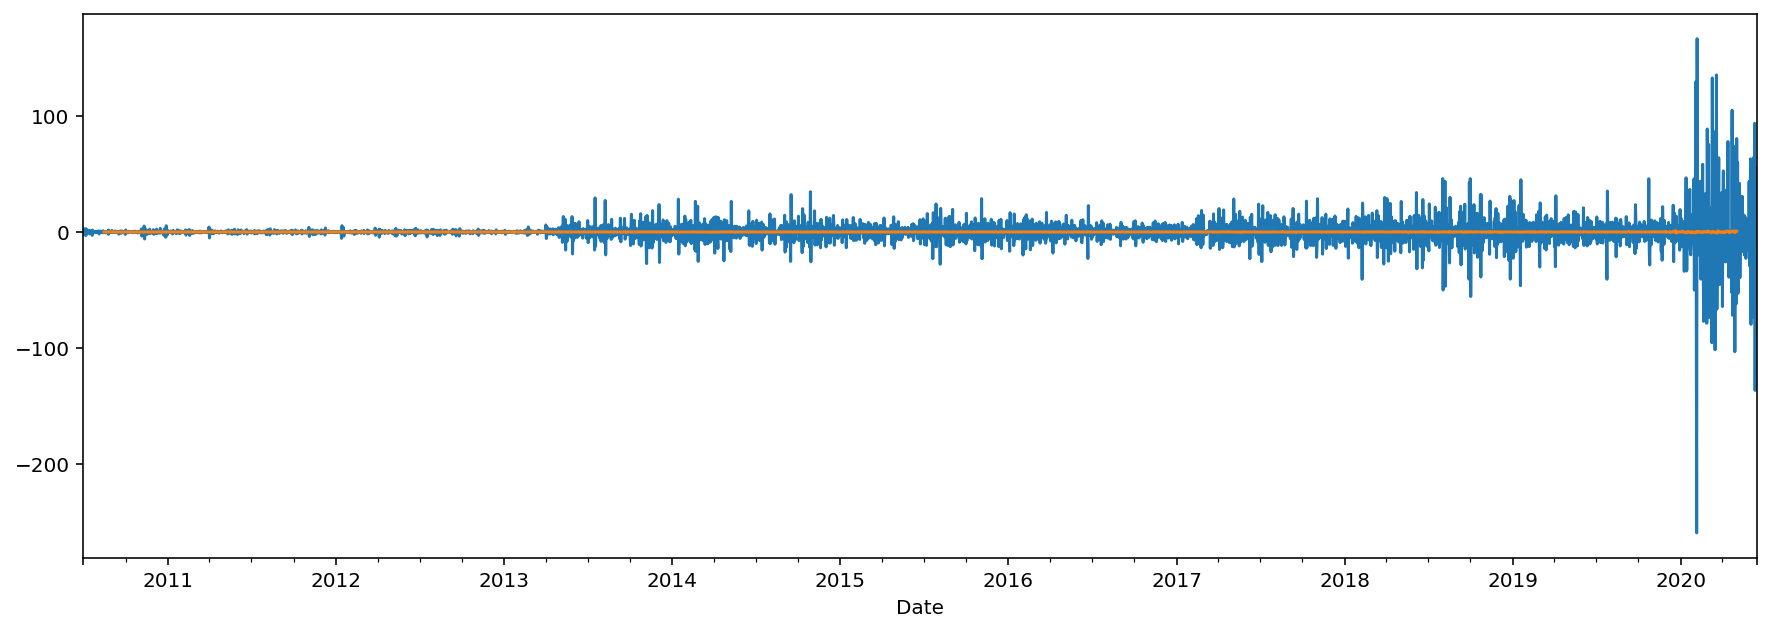

In [14]:
n = seasonal_decompose(df['diff_close_2'].dropna(), period = 90)
n.observed.plot(figsize = (15, 5))
n.trend.plot()

print(adf_results(df['diff_close_2'].dropna()))

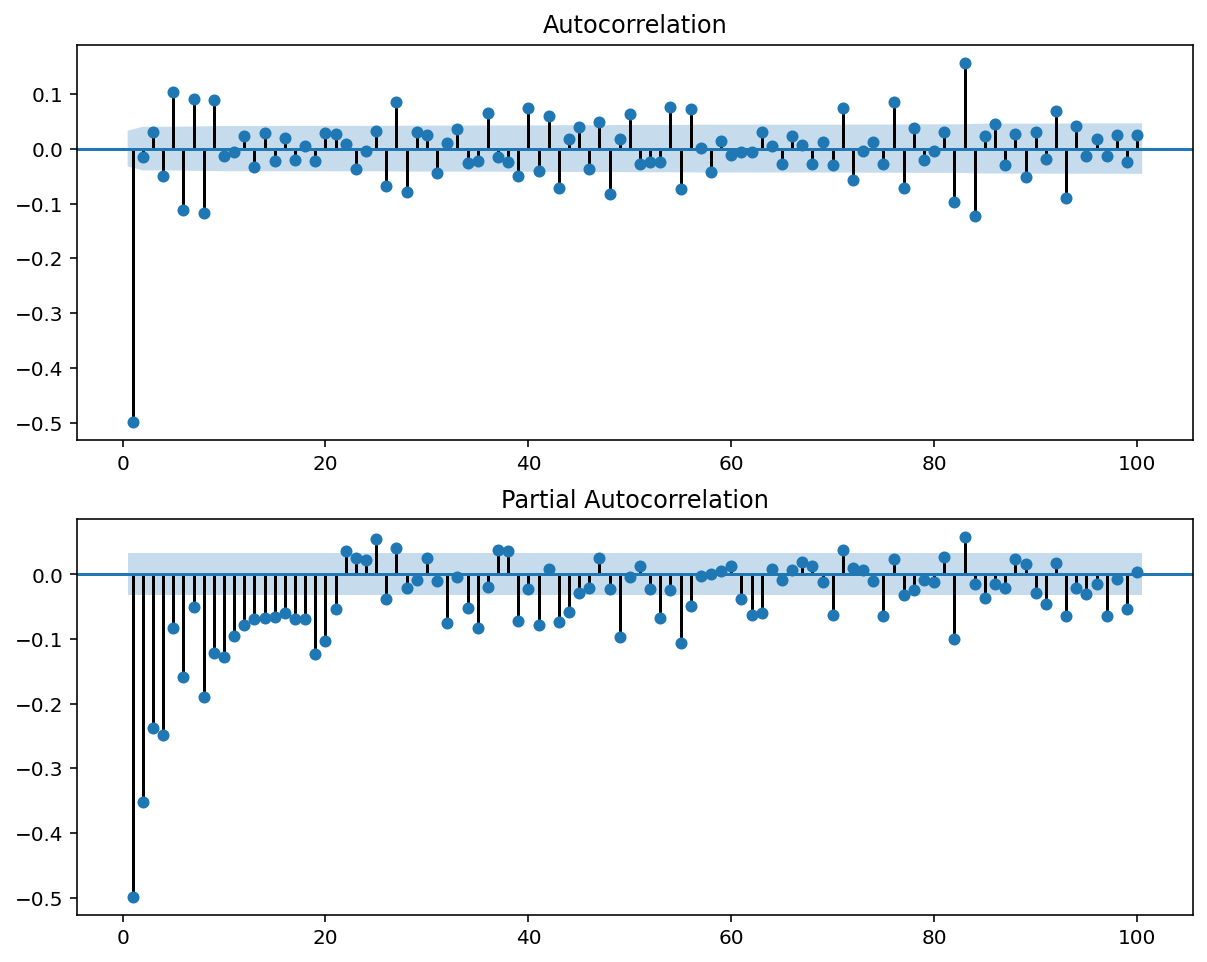

In [15]:
# We can see at lag-1 that the ACF and PACF values are extreme and negative which indicates overdifferencing.
# Because of all the noise in our first-differenced correlogram 
# we're going to try other methods to stationarize.
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
plot_acf(df['diff_close_2'].dropna(), lags = 100, ax = ax[0], zero = False)
plot_pacf(df['diff_close_2'].dropna(), lags = 100, ax = ax[1], zero = False);

# Log Transformation of Closing Price

In [16]:
# In an attempt to smooth out the exponential trend, I'm going to take the log of the closing price. 
df['log_close'] = np.log(df['close'])

# Check to see if the logged closing price is stationary:
print(adf_results(df['log_close']), '\n')

# Because our p-value is again way higher than our alpha level of 0.01, we will take the first order difference
# and check for stationarity 
df['log_diff'] = df['log_close'].diff()

# Our p-value here with the differenced logged prices is practically 0. We can proceed with stationarity assumption.
adf_results(df['log_diff'].dropna())

Test Statistic   -0.588523
p-value           0.873554
dtype: float64 



Test Statistic   -60.984457
p-value            0.000000
dtype: float64

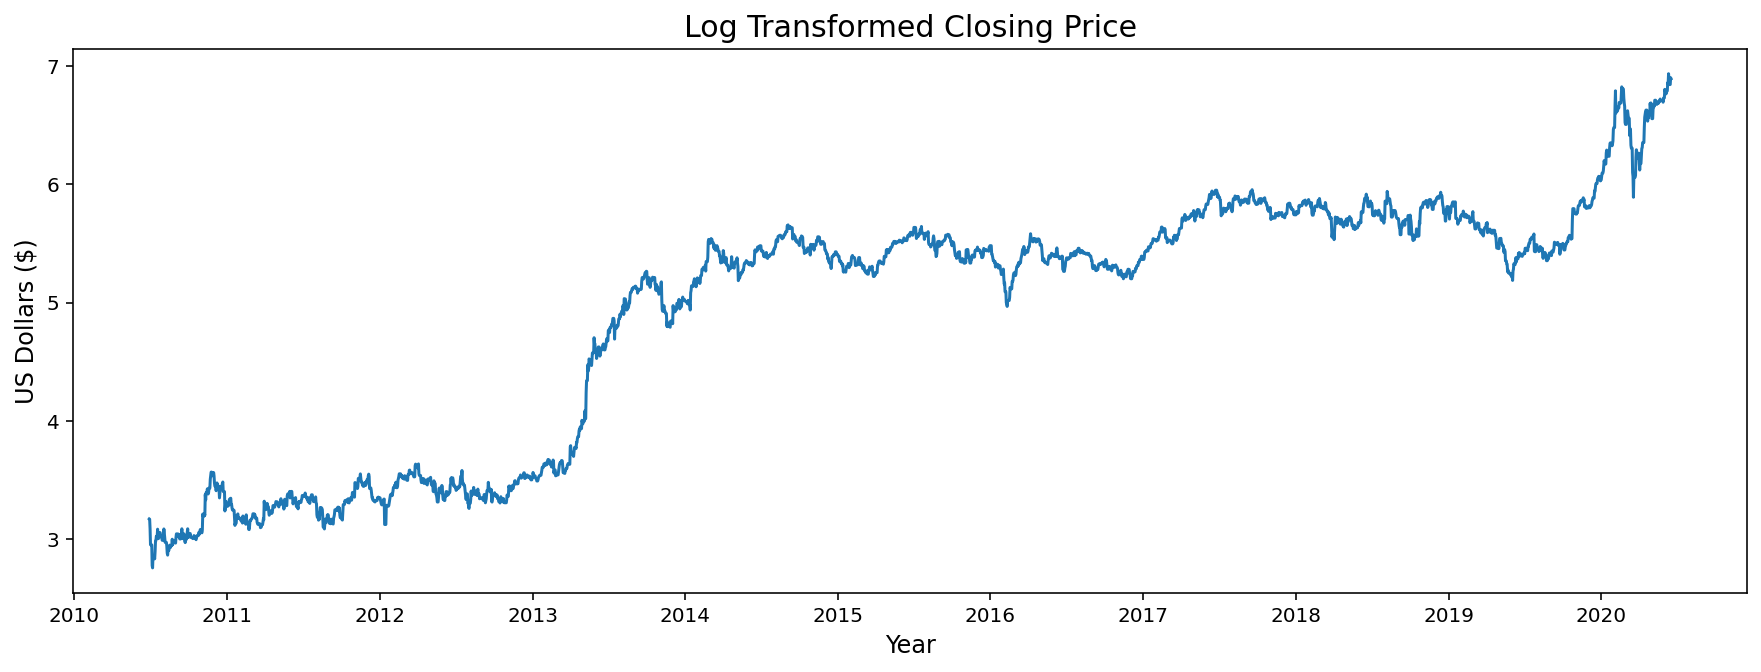

In [17]:
plt.figure(figsize = (15, 5))
plt.plot(df['log_close'])
plt.xlabel('Year', size = 12)
plt.ylabel('US Dollars ($)', size = 12)
plt.title('Log Transformed Closing Price', size = 15);

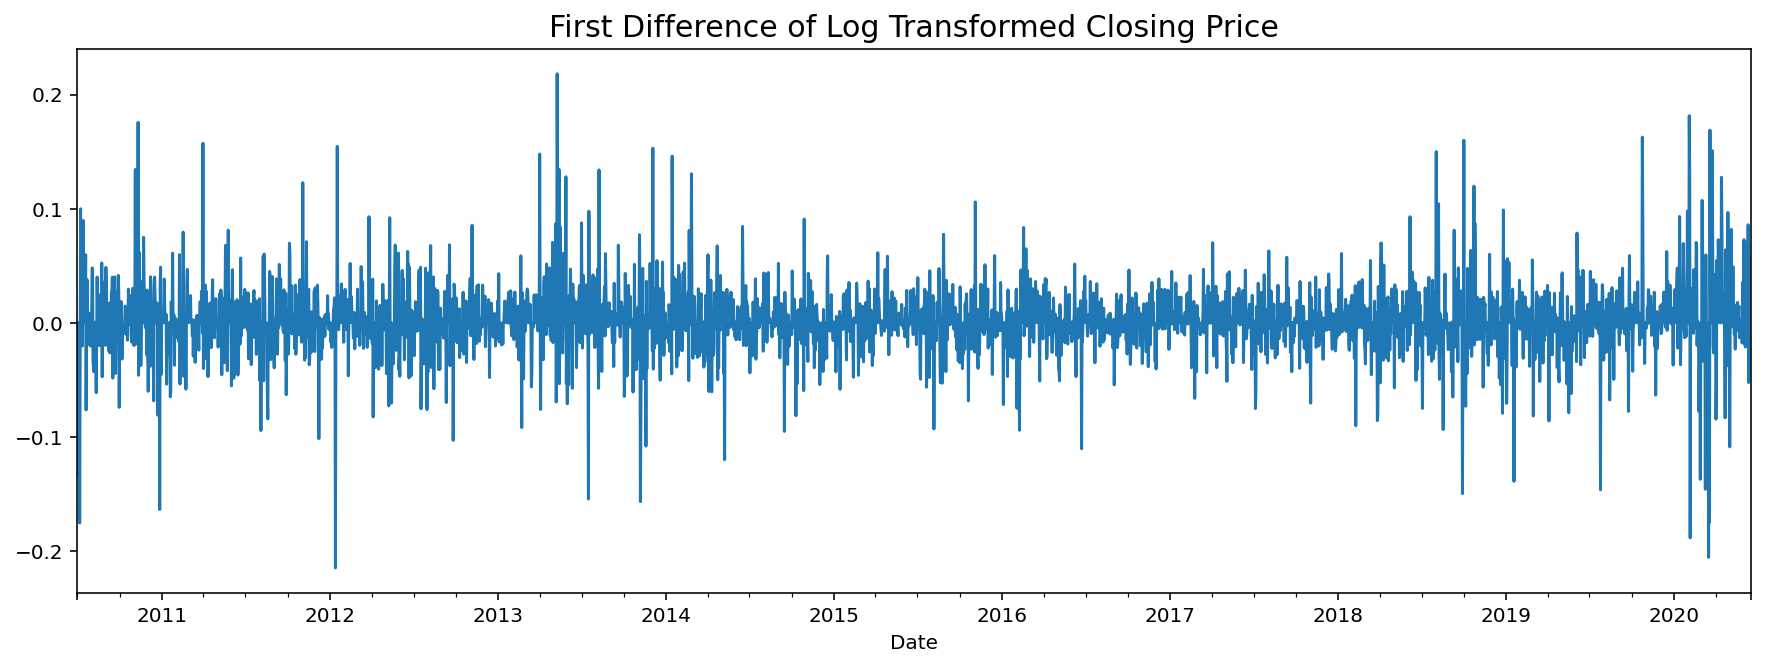

In [18]:
n = seasonal_decompose(df['log_diff'].dropna())
n.observed.plot(figsize = (15, 5))
plt.title('First Difference of Log Transformed Closing Price', size = 15);

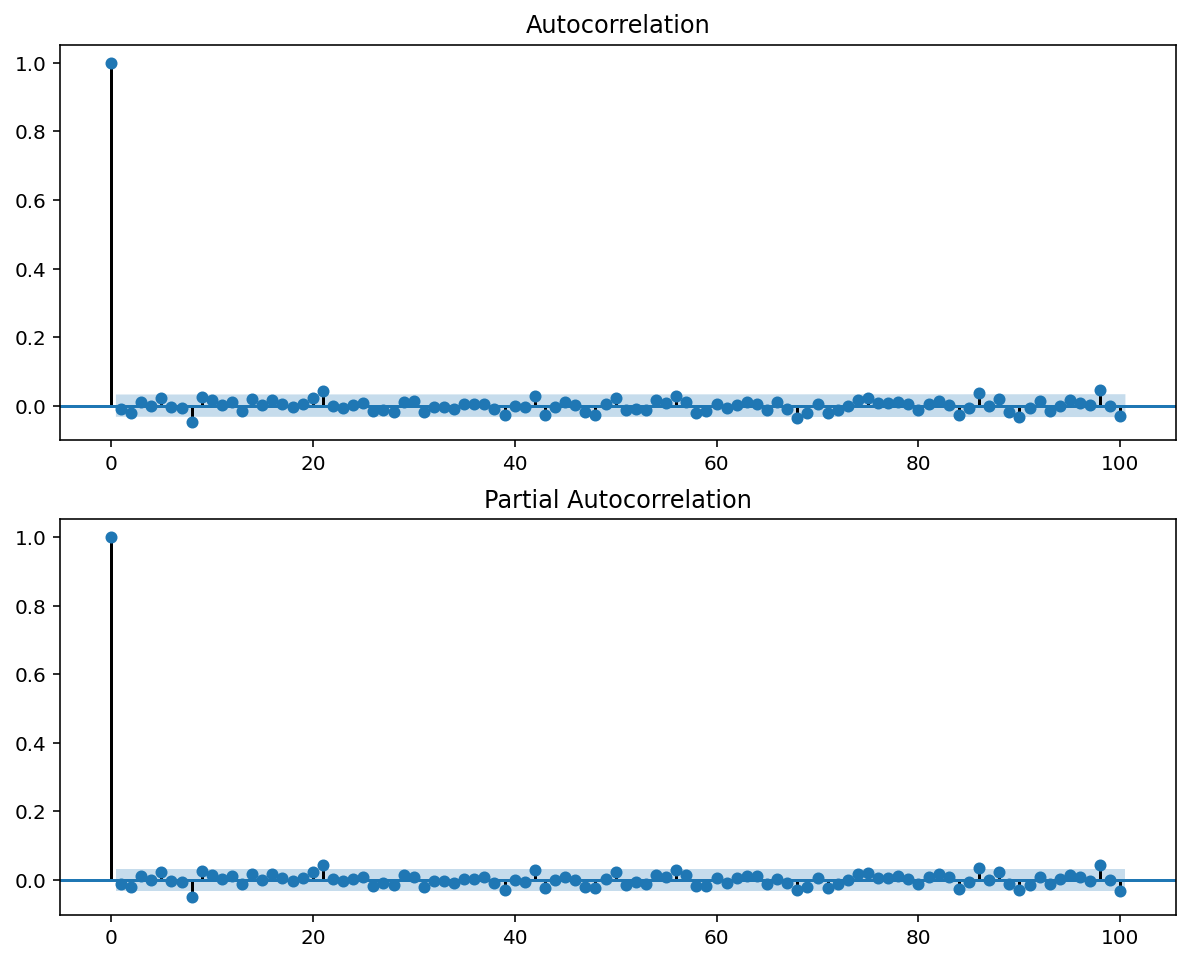

In [19]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
plot_acf(df['log_diff'].dropna(), lags = 100, ax = ax[0])
plot_pacf(df['log_diff'].dropna(), lags = 100, ax = ax[1]);

# ARIMA Model (Closing Price)

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [21]:
# Train test split our y variable (First order difference of the logged closing price)
# leaving the most recent 10% of our data as our test set.
y_train, y_test = train_test_split(df['log_close'],
                                   test_size = 0.10,
                                   shuffle = False)

In [22]:
model = ARIMA(endog = y_train.dropna(),
              order = (0, 1, 0))
arima = model.fit()

preds = model.predict(arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.log_close   No. Observations:                 3275
Model:                 ARIMA(0, 1, 0)   Log Likelihood                7197.036
Method:                           css   S.D. of innovations              0.027
Date:                Tue, 16 Jun 2020   AIC                         -14390.072
Time:                        14:41:53   BIC                         -14377.884
Sample:                    06-30-2010   HQIC                        -14385.708
                         - 06-17-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.458      0.145      -0.000       0.002
==============================================================================
"""

In [23]:
preds = pd.Series(np.r_[df['log_close'][y_test.index][0], preds[:8]].cumsum())

preds.index = df['log_close'][y_test.index][:9].index
preds

Date
2019-06-18    5.414944
2019-06-19    5.415629
2019-06-20    5.416314
2019-06-21    5.416999
2019-06-22    5.417683
2019-06-23    5.418368
2019-06-24    5.419053
2019-06-25    5.419738
2019-06-26    5.420423
Freq: D, dtype: float64

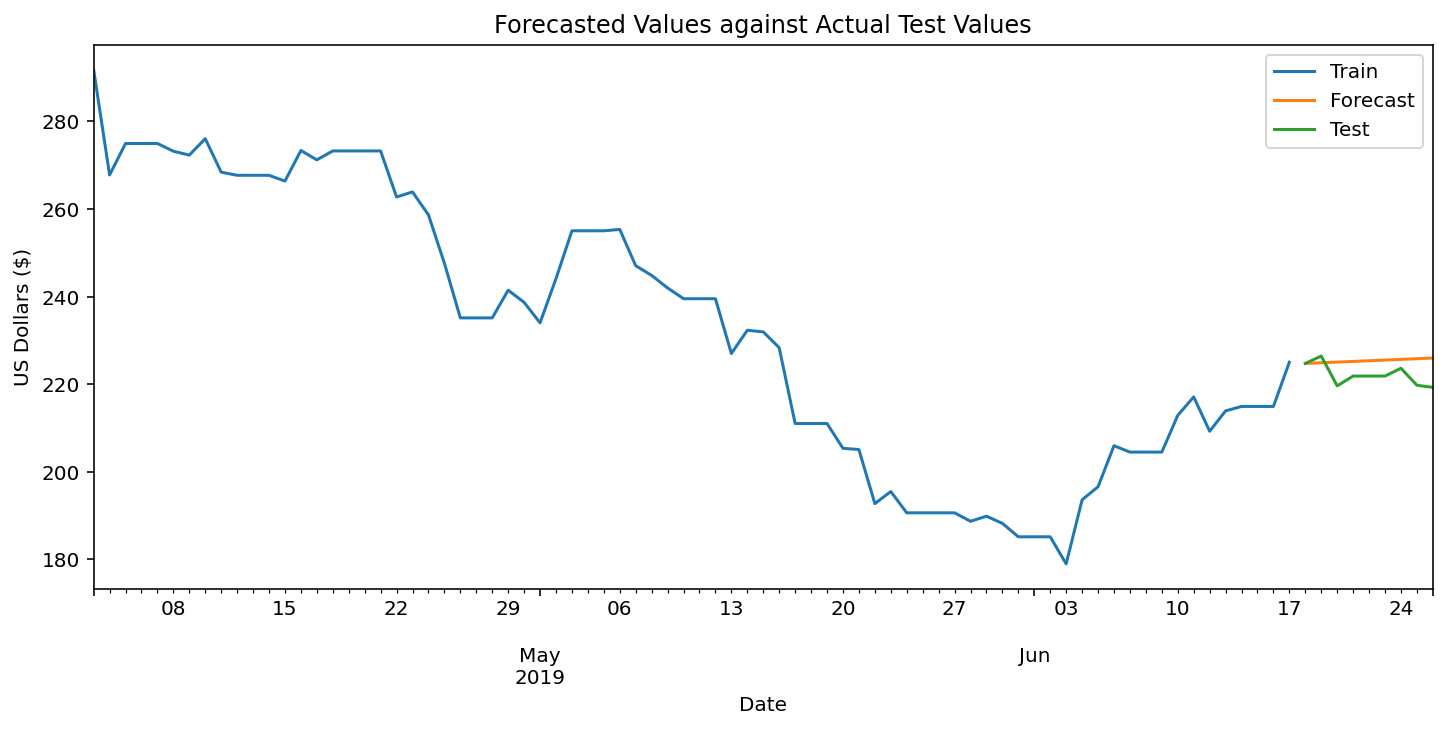

In [24]:
plt.figure(figsize = (12, 5))
np.exp(df['log_close'][y_train.index][3200:]).plot(label = 'Train')
np.exp(preds).plot(label = 'Forecast')
np.exp(df['log_close'][y_test.index][:9]).plot(label = 'Test')
plt.title('Forecasted Values against Actual Test Values')
plt.ylabel('US Dollars ($)')
plt.legend();

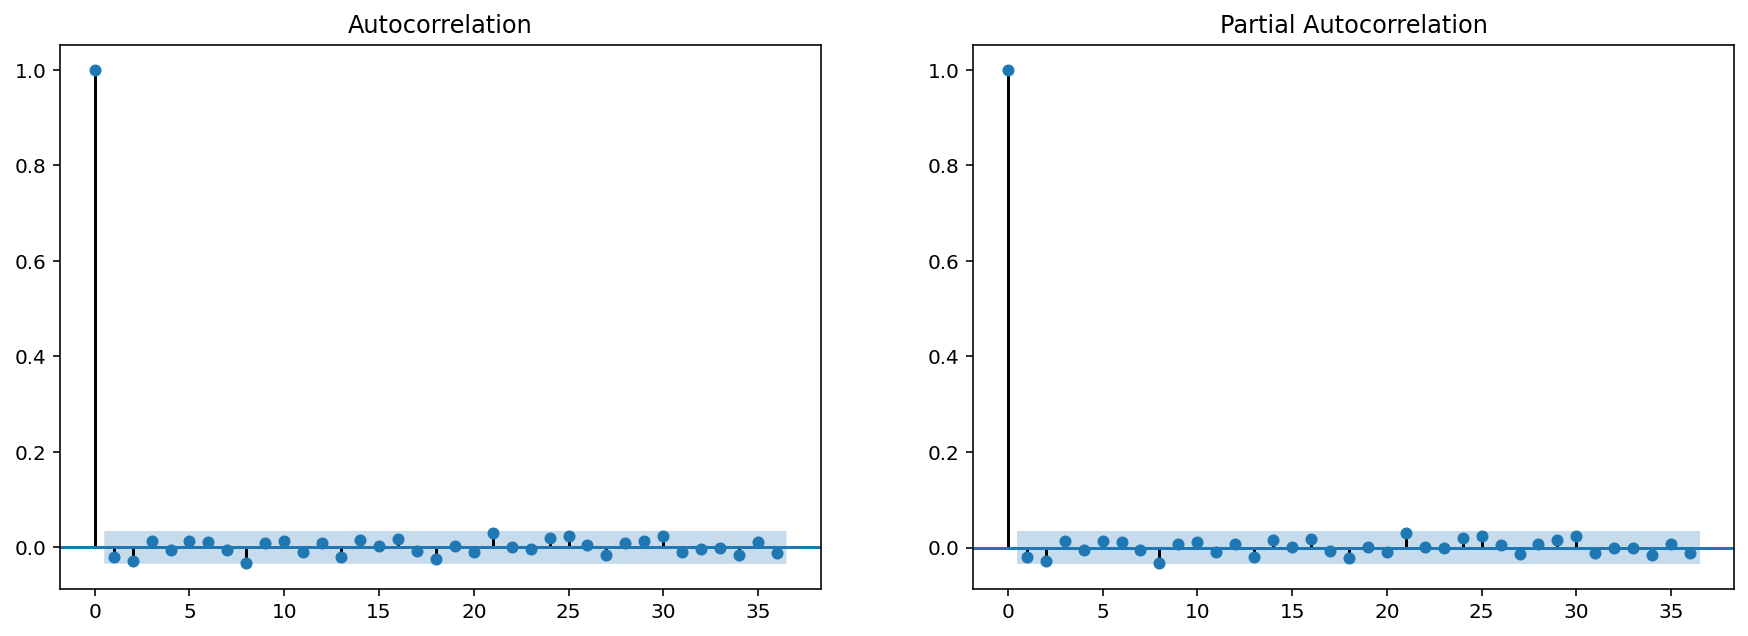

In [25]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_acf(arima.resid, ax = ax[0])
plot_pacf(arima.resid, ax = ax[1]);

# Recurrent Neural Network (LSTM)

In [26]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [27]:
new_df = df.iloc[:, :7].copy().dropna()

new_df.head()

,open,high,low,close,adj_close,volume,daily_returns
Date,,,,,,,
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100.0,-0.002512
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800.0,-0.078473
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683
2010-07-03,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683
2010-07-04,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683


In [28]:
training_data = new_df[new_df.index.year < 2019].copy()

training_data.drop(columns = 'adj_close', inplace = True)

In [29]:
test_data = new_df[new_df.index.year >= 2019].copy()

test_data.drop(columns = 'adj_close', inplace = True)

In [30]:
mm = MinMaxScaler()
training_data_sc = mm.fit_transform(training_data)
training_data_sc

array([[0.02604237, 0.03697249, 0.02283393, 0.02174973, 0.46074816,
        0.4363037 ],
       [0.0239104 , 0.0249075 , 0.01451821, 0.01668472, 0.21865873,
        0.26256929],
       [0.01851302, 0.01734677, 0.01023685, 0.0092091 , 0.13554449,
        0.15459157],
       ...,
       [0.82839023, 0.85690922, 0.83275242, 0.86151138, 0.26509364,
        0.57039412],
       [0.82839023, 0.85690922, 0.83275242, 0.86151138, 0.26509364,
        0.57039412],
       [0.868034  , 0.86487211, 0.85155199, 0.85861322, 0.16692491,
        0.43471795]])

In [31]:
X_train = []
y_train = []

In [32]:
for i in range(60, training_data_sc.shape[0]):
    X_train.append(training_data_sc[i-60: i])
    y_train.append(training_data_sc[i, 3])

In [33]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [34]:
print(X_train.shape)

print(y_train.shape)

(3047, 60, 6)
(3047,)


In [35]:
model = Sequential()

# First LSTM layer w/ 0.2 Dropout
model.add(LSTM(units = 50,
               activation = 'relu',
               return_sequences = True,
               input_shape = (X_train.shape[1], 6)))
model.add(Dropout(0.2))

# Second LSTM layer w/ 0.2 Dropout
model.add(LSTM(units = 50,
               activation = 'relu',
               return_sequences = True))
model.add(Dropout(0.2))

# Third LSTM layer w/ 0.2 Dropout
model.add(LSTM(units = 50,
               activation = 'relu',
               return_sequences = True))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

In [36]:
model.compile(optimizer = Adam(), loss = 'mse')

In [37]:
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
96/96 [==============================] - 7s 71ms/step - loss: 0.0554
Epoch 2/10
96/96 [==============================] - 6s 61ms/step - loss: 0.0153
Epoch 3/10
96/96 [==============================] - 6s 59ms/step - loss: 0.0115
Epoch 4/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0095
Epoch 5/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0084
Epoch 6/10
96/96 [==============================] - 6s 59ms/step - loss: 0.0079
Epoch 7/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0074
Epoch 8/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0072
Epoch 9/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0067
Epoch 10/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0066


In [38]:
past_60 = training_data.tail(60)

df = past_60.append(test_data)

df

,open,high,low,close,volume,daily_returns
Date,,,,,,
2018-11-02,343.74,349.20,340.91,346.41,7808000.0,0.006187
2018-11-03,343.74,349.20,340.91,346.41,7808000.0,0.006187
2018-11-04,343.74,349.20,340.91,346.41,7808000.0,0.006187
2018-11-05,340.50,343.96,330.14,341.40,7831000.0,-0.014463
2018-11-06,339.07,348.80,336.09,341.06,6762900.0,-0.000996
...,...,...,...,...,...,...
2020-06-12,980.00,987.98,912.60,935.28,16730200.0,-0.038609
2020-06-13,980.00,987.98,912.60,935.28,16730200.0,-0.038609
2020-06-14,980.00,987.98,912.60,935.28,16730200.0,-0.038609


In [39]:
inputs = mm.transform(df)
inputs

array([[0.88409122, 0.89165639, 0.89450284, 0.89547671, 0.20756963,
        0.45619812],
       [0.88409122, 0.89165639, 0.89450284, 0.89547671, 0.20756963,
        0.45619812],
       [0.88409122, 0.89165639, 0.89450284, 0.89547671, 0.20756963,
        0.45619812],
       ...,
       [2.60116044, 2.60429514, 2.46348492, 2.49046587, 0.44841465,
        0.35374412],
       [2.43327486, 2.63341198, 2.45223262, 2.64111593, 0.41958516,
        0.57806218],
       [2.68711375, 2.67105475, 2.6005434 , 2.61736186, 0.37274547,
        0.42180537]])

In [40]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 3])

In [41]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((533, 60, 6), (533,))

In [42]:
y_pred = model.predict(X_test)

In [43]:
mm.scale_

array([2.69869113e-03, 2.68110891e-03, 2.74446305e-03, 2.70855905e-03,
       2.69939048e-08, 2.28715263e+00])

In [47]:
y_pred = y_pred * 1/2.70855905e-03
y_test = y_test * 1/2.70855905e-03